In [5]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv 
import matplotlib.cm as cm

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Flatten, InputLayer
from keras.optimizers import SGD

from keras.models import load_model
import h5py


import chess, chess.pgn, chess.svg, chess.polyglot
from IPython.display import SVG

import h5py


import chess, chess.pgn
import chess.engine
import numpy
import sys
import os
import multiprocessing
import itertools
import random
import h5py

from sklearn.preprocessing import Normalizer

# Section 1: Restructure data

Here, we load in data from a pgn file and parse each game's states into tensors

In [3]:
def read_games(filename):
    f = open(filename)

    while True:
        try:
            g = chess.pgn.read_game(f)
        except KeyboardInterrupt:
            raise
        except:
            continue

        if not g:
            break
        
        yield g

def encode(board):
    # Initialize matrix to hold encoded board
    # Each encoded board will be 8x8 with 12 channels at each square. 
    # Piece types are given as:
    # P - 1, N - 2, B - 3, R - 4, Q - 5, K - 6
    # White pieces occupy the first 6 indices, bladck pieces occupy the last 6 indices
    # [P, N, B, R, Q, K, p, n, b, r, q, k]
    encodedBoard = np.zeros((768,), dtype=np.int) 
    
    # Loop through each of the 64 positions on the board
    # Position 0 is where the Queen's rook initially starts
    for i in range(64):
        # Check if piece exists at specified square
        piece = board.piece_at(i)
        
        if piece is not None:
            # Get piece information
            piece_type = board.piece_at(i).piece_type
            piece_color = board.piece_at(i).color
            
            # Adj = 0 if white, 
            adj = 0
            if piece_color == False:
                adj = 6
            
            # If piece belongs to playing player, then 
            if piece_color == board.turn:
                encodedBoard[i*12+(adj + piece_type-1)] = 1
            else:
                encodedBoard[i*12+(adj + piece_type-1)] = -1
                
    return encodedBoard

def parse_game(game, game_evals, verbose=False):
    game_evals = game_evals[1].split(" ")
    
    # Holds all board states after first move (does NOT include initial board position)
    states = []
    
    # Holds evaluations for board states
    evals = []
    
    # Get board from game object
    board = game.board()
    
    # For each move
    for move, ev in zip(game.mainline_moves(), game_evals):
        try:
            # Push the move onto the board
            board.push(move)
            
            board_fen = board.fen()
            
            if board_fen in unique_fens:
                continue
            else:
                unique_fens.add(board_fen)
            
            # Add the new evaluation
            if board.turn:
                evals.append(int(ev))
            else:
                evals.append(-1 * int(ev))

            # Encode the new board
            new_state = encode(board)

            # Add this new board state to states
            states.append(new_state)
            
        except ValueError:
            if verbose:
                print("States added: ", len(states))
                print(" Evals added: ", len(evals))
            return states, evals

    if verbose:
        print("States added: ", len(states))
        print(" Evals added: ", len(evals))
        
    return states, evals

def readAllGames(PGNname, CSVname, max_boards = 1000000, verbose=False):
    # Read in all csv entries
    
    # Holds all stockfish evaluation scores from csv
    all_game_evals = [] 

    # reading csv file 
    with open(CSVname, 'r') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 

        # extracting field names through first row 
        fields = next(csvreader)

        # extracting each data row one by one 
        for row in csvreader: 
            all_game_evals.append(row)    
    
    # Define lists to hold board vectors and stockfish evaluations
    x_train = []
    y_train = []
    
    game_id = 1
    
    # Each game should have a corresponding game_evals row in stockfish_evals
    for game, game_evals in zip(read_games(PGNname), all_game_evals):
        if game_id % 1000 == 1 and verbose:
            print("Game {}".format(game_id))
            print("Number of states so far: ", len(x_train))
        
        # Parse information for game
        states, evals = parse_game(game, game_evals)
        
        # Add each board vector and stockfish evaluation
        for b, ev in zip(states, evals):
            x_train.append(b)
            y_train.append(ev)
        
        game_id += 1
        # Set maximum board states to store
        if len(x_train) > max_boards:
            break
    
    print(len(x_train), " states converted")
    
    # Convert to numpy array
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    
    print(len(x_train), " total board states saved!")
    return x_train, y_train

In [4]:
# Get x_train and y_train
unique_fens = set([])
x_all, y_all = readAllGames("data/data.pgn", "data/stockfish.csv", max_boards=3000000, verbose=True)

Game 1
Number of states so far:  0
Game 1001
Number of states so far:  73967
Game 2001
Number of states so far:  145702
Game 3001
Number of states so far:  215962
Game 4001
Number of states so far:  286101
Game 5001
Number of states so far:  358730
Game 6001
Number of states so far:  428669
Game 7001
Number of states so far:  497217
Game 8001
Number of states so far:  569189
Game 9001
Number of states so far:  636502
Game 10001
Number of states so far:  706749
Game 11001
Number of states so far:  774112
Game 12001
Number of states so far:  843194
Game 13001
Number of states so far:  911982
Game 14001
Number of states so far:  979922
Game 15001
Number of states so far:  1047485
Game 16001
Number of states so far:  1117895
Game 17001
Number of states so far:  1185578
Game 18001
Number of states so far:  1251821
Game 19001
Number of states so far:  1321683
Game 20001
Number of states so far:  1389599
Game 21001
Number of states so far:  1458448
Game 22001
Number of states so far:  1524567

In [5]:
x_all.shape

(3000036, 768)

(array([1., 2., 2., ..., 2., 0., 2.]),
 array([-12352.        , -12350.29439381, -12348.58878763, ...,
         12348.58878763,  12350.29439381,  12352.        ]),
 <a list of 14484 Patch objects>)

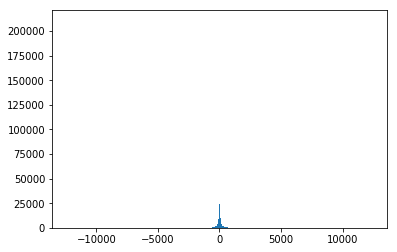

In [6]:
plt.hist(y_all, bins='auto')

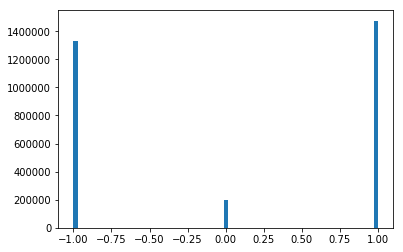

In [13]:
# from sklearn.preprocessing import Normalizer

# y_all_normalized = y_all.copy()

# print(y_all_normalized.shape)

# y_all_normalized = y_all_normalized.reshape((len(y_all_normalized), 1))

# transformer = Normalizer()

# y_all_normalized = transformer.fit_transform(y_all_normalized)

# plt.hist(y_all_normalized, bins='auto')

# y_capped = y_all.copy()

# for i in range(len(y_capped)):
#     y_capped[i] = max(-500, y_capped[i])
#     y_capped[i] = min(500, y_capped[i])

# plt.hist(y_capped, bins='auto')

y_capped = y_capped.reshape((len(y_capped), 1))

transformer = Normalizer()

y_capped = transformer.fit_transform(y_capped)

plt.hist(y_capped, bins='auto')

plt.show()

In [8]:
hf = h5py.File('data/data.h5', 'w')

# Save x_train and y_train to an H5 file
hf.create_dataset('boards', data=x_train)
hf.create_dataset('labels', data=y_train)

hf.close()

In [9]:
# Verify that x_train and y_train were properly stored
hf_test = h5py.File('data/data.h5', 'r')

x_train = hf_test.get('boards')
y_train = hf_test.get('labels')

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train.shape)
print(y_train.shape)

hf_test.close()

(3000043, 768)
(3000043,)


In [4]:
import chess.engine
engine = chess.engine.SimpleEngine.popen_uci("engines/stockfish")

In [1]:
board = chess.Board("2k5/p4ppp/4p3/3p4/3P4/2b2P2/6PP/6K1 w - - 2 27")
info = engine.analyze(board, chess.engine.Limit(depth=20))

t = info["score"].cp

# if t.startswith('#'):
#         print(" eval = mate in ", t)
# else: print(" eval = ", round(int(t)/100.,2))

NameError: name 'chess' is not defined

In [21]:
class Parser:
    def __init__(self, engine_name, verbose=False):
        self.engine = chess.engine.SimpleEngine.popen_uci(engine_name)
        self.unique_boards = set([])
        
        self.verbose = verbose

    def read_games(self, filename):
        f = open(filename)

        while True:
            try:
                g = chess.pgn.read_game(f)
            except KeyboardInterrupt:
                raise
            except:
                continue

            if not g:
                break

            yield g

    def encode(self, board):
        # Initialize matrix to hold encoded board
        # Each encoded board will be 8x8 with 12 channels at each square. 
        # Piece types are given as:
        # P - 1, N - 2, B - 3, R - 4, Q - 5, K - 6
        # White pieces occupy the first 6 indices, bladck pieces occupy the last 6 indices
        # [P, N, B, R, Q, K, p, n, b, r, q, k]
        encodedBoard = np.zeros((768,), dtype=np.int) 

        # Loop through each of the 64 positions on the board
        # Position 0 is where the Queen's rook initially starts
        for i in range(64):
            # Check if piece exists at specified square
            piece = board.piece_at(i)

            if piece is not None:
                # Get piece information
                piece_type = board.piece_at(i).piece_type
                piece_color = board.piece_at(i).color

                # Adj = 0 if white, 
                adj = 0
                if piece_color == False:
                    adj = 6

                # If piece belongs to playing player, then 
                if piece_color == board.turn:
                    encodedBoard[i*12+(adj + piece_type-1)] = 1
                else:
                    encodedBoard[i*12+(adj + piece_type-1)] = -1

        return encodedBoard

    def parse_game(self, game, verbose=False):
        # Get board from game object
        board = game.board()

        boards = []
        evals = []
        
        # For each move
        for move in game.mainline_moves():
            # Push the move onto the board
            board.push(move)

            board_fen = board.fen()

            if board_fen in self.unique_boards:
                continue
            else:
                self.unique_boards.add(board_fen)

            # Get stockfish evaluation
            ev = self.engine.analyse(board, chess.engine.Limit(depth=20))
            ev = str(ev["score"])
            
            if ev.startswith('#'):
                ev = -100
            else:
                ev = int(ev)
                
                if board.turn:
                    evals.append(ev)
                else:
                    evals.append(-1 * ev)
            
            # Encode the new board
            new_board = self.encode(board)

            # Add this new board state to states
            boards.append(new_board)
            
        if verbose:
            print("States added: ", len(boards))
            print(" Evals added: ", len(evals))

        return boards, evals

    def readPGN(self, PGNname, max_boards = 1000000):
        if self.verbose:
            print("Reading {}".format(PGNname))
            
        # Clear lists to hold board vectors and stockfish evaluations
        x_all = []
        y_all = []
        
        # Game counter
        game_id = 1

        # Each game should have a corresponding game_evals row in stockfish_evals
        for game in self.read_games(PGNname):
            if game_id % 10 == 1 and self.verbose:
                print("Game {}".format(game_id))
                print("Number of states so far: ", len(x_all))

            # Parse information for game
            boards, evals = self.parse_game(game)

            for board, ev in zip(boards, evals):
                x_all.append(board)
                y_all.append(ev)
            
            game_id += 1
            
            # Check if maximum board states reached
            if len(x_all) > max_boards:
                break

        print(len(y_all), " states converted")

        # Convert to numpy array
        x_all = np.asarray(x_all)
        y_all = np.asarray(y_all)

        print(len(y_all), " total board states saved!")
        
        return x_all, y_all
    
    def saveData(self, out_name):
        hf = h5py.File(out_name, 'w')

        # Save x_train and y_train to an H5 file
        hf.create_dataset('boards', data=self.x_all)
        hf.create_dataset('labels', data=self.y_all)

        hf.close()

In [22]:
parser = Parser("engines/stockfish", verbose=True)
parser.readPGN("data/data.pgn", max_boards=300)

Reading data/data.pgn
Game 1
Number of states so far:  0
334  states converted
334  total board states saved!


(array([[ 0,  0,  0, ...,  1,  0,  0],
        [ 0,  0,  0, ..., -1,  0,  0],
        [ 0,  0,  0, ...,  1,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]]),
 array([   -8,    75,     4,    59,   -15,    54,   -24,    78,    -6,
           71,    -6,    44,   -16,    31,   -63,    -6,  -119,    38,
          -91,   -28,   -38,   -12,   -55,   104,    66,    97,    61,
           75,    61,    93,    30,    83,    27,    73,    19,    69,
           13,    55,     5,    45,     1,   113,     5,    64,    13,
           92,    32,   114,    47,   121,    56,   103,    42,   106,
           35,   108,    54,   112,    52,   131,    24,    95,    52,
           91,    30,   112,    -4,    42,   -43,    23,   -14,    13,
          -43,    14,   -24,    38,    -4,    61,     0,    13,   -32,
           23,   -13,     0,   -17,    28,   -30,    26,     0,    39,
            7,    50,   -59,     0,   -37